# Import Library

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
import datetime as dt
from matplotlib.ticker import PercentFormatter
# import os
# from fredapi import Fred

import marketobserve as mo

In [ ]:
def options_chain(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options
    # print(exps[1])
    # Get options for each expiration
    options = pd.DataFrame()
    options_list = []
    for e in exps:
        opt = tk.option_chain(e)
        calls_puts = pd.concat([opt.calls, opt.puts])
        calls_puts['expirationDate'] = e
        options_list.append(calls_puts)
    
    # Combine all options data
    options = pd.concat(options_list, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + dt.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - dt.datetime.today()).dt.days / 365
    
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options

In [ ]:
# options_chain("^GSPC")
# options_chain("^HSI")

# Monthly Return Distribution

In [ ]:
def yf_download(ticker, start_date, end_date, frequency='1d', progress=True, auto_adjust=False):
    """
    Download stock data from Yahoo Finance
    
    Parameters:
    - ticker: Stock symbol (e.g., "^HSI")
    - start_date: datetime.date or string in YYYY-MM-DD format
    - end_date: datetime.date or string in YYYY-MM-DD format
    - frequency: Data frequency ('1d', '1wk', '1mo')
    - progress: Show download progress bar
    - auto_adjust: Adjust all OHLC automatically
    
    Returns:
    - DataFrame with stock data
    """
    df = yf.download(
        ticker, 
        start=start_date, 
        end=end_date,
        interval=frequency,
        progress=progress, 
        auto_adjust=auto_adjust
    )
    df.columns = df.columns.droplevel(1)
    df.set_index(pd.DatetimeIndex(df.index), inplace=True)
    # Reorder columns as specified
    df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return df

# Example usage:
start = dt.date(1900, 1, 1)
end = dt.date(2026, 1, 1)
ticker = "^HSI"
data = yf_download(ticker, start, end)
# data.index = data.index.strftime('%Y-%m')
data.to_excel(f"{ticker}.xlsx")


# download data from local file
# data = pd.read_excel("spx.xlsx",index_col="Date")
# data.columns = ["Close"]
# data = data.sort_index(ascending=True)

# # download data from xbbg
# from xbbg import blp
# data = blp.bdh("SPX Index","PX_LAST","1900-01-01") # HSI, NKY, SPX
# data.columns = ["Close"]
# data = data.sort_index(ascending=True)

In [ ]:
# data
data.describe()

In [108]:
def refrequency(df, frequency:str):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex")
    if not {'Open', 'High', 'Low', 'Close'}.issubset(df.columns):
        raise ValueError("DataFrame must contain OHLC columns")

    # Create refrequency dataframes
    try:
        refrequency_df = df.resample(frequency).agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Adj Close': 'last',
            'Volume': 'sum'
        }).dropna()
    except Exception as e:
        raise ValueError(f"Error processing monthly data: {str(e)}") 

    return refrequency_df

def oscillation(df):
        data = df[['Open', 'High', 'Low', 'Close']].copy()  # Create copy to avoid warnings
        data['LastClose'] = data["Close"].shift(1)
        data["Oscillation"]=  data["High"] - data["Low"]  
        data["OscillationPct"] = data["Oscillation"] / data['LastClose'] * 100
        data = data[['LastClose','Oscillation','OscillationPct']]
        data = data.dropna()
        return data

def tail_stats(df, feature, periods: list = [12, 36, 60, "ALL"], all_period_start: str = None, interpolation: str = "linear"):

    if not isinstance(periods, list):
        raise TypeError("periods must be a list")
    if not all(isinstance(p, (int, str)) for p in periods):
        raise ValueError("periods must contain integers or strings")

    data_sources = {}

    df = df[feature].copy()
    # Remove rows in df where the index is in curren month
    current_date = pd.Timestamp.now()
    df = df[df.index < current_date.replace(day=1)]  # Exclude current month completely 

    last_date = df.index[-1]

    if all_period_start == None:
        all_period_start = "2010-01-01"
    
    for period in periods:
        if isinstance(period, int):
            start_date = last_date - pd.DateOffset(months=period-1)
            col_name = f"{start_date.strftime('%y%b')}-{last_date.strftime('%y%b')}"
            data_sources[col_name] = df.loc[df.index >= start_date]
        elif period == "ALL":
            col_name = f"{pd.to_datetime(all_period_start).strftime('%y%b')}-{last_date.strftime('%y%b')}" 
            data_sources[col_name] = df.loc[df.index >= all_period_start]
        else:
            raise ValueError("Invalid period value")

    # Calculate statistics
    stats_index = pd.Index(["mean", "std", "skew", "kurt", "max", "99th", "95th", "90th"])
    stats_df = pd.DataFrame(index=stats_index)

    for period_name, data in data_sources.items():
        stats_df[period_name] = [
            data.mean(),
            data.std(),
            data.skew(),
            data.kurtosis(),
            data.max(),
            data.quantile(0.99,interpolation=interpolation),
            data.quantile(0.95,interpolation=interpolation),
            data.quantile(0.90,interpolation=interpolation)
        ]
    
    return stats_df

def tail_plot(df, feature, periods: list = [12, 36, 60, "ALL"], all_period_start: str = None, interpolation: str = "linear"):
    """Plot distribution of feature values for different time periods"""
    # Create data sources like in tail_stats
    data_sources = {}
    df = df[feature].copy()
    current_date = pd.Timestamp.now()
    df = df[df.index < current_date.replace(day=1)]
    last_date = df.index[-1]
    
    if all_period_start is None:
        all_period_start = "2010-01-01"
    
    for period in periods:
        if isinstance(period, int):
            start_date = last_date - pd.DateOffset(months=period-1)
            col_name = f"{start_date.strftime('%y%b')}-{last_date.strftime('%y%b')},{period}M"
            data_sources[col_name] = df.loc[df.index >= start_date]
        elif period == "ALL":
            col_name = f"{pd.to_datetime(all_period_start).strftime('%y%b')}-{last_date.strftime('%y%b')}"
            data_sources[col_name] = df.loc[df.index >= all_period_start]

    # Plot each period
    for period_name, data in data_sources.items():
        plt.figure(figsize=(12, 8))
        # Use seaborn style
        sns.set_style("darkgrid")        
        # Plot histogram and density
        n, bins, patches = plt.hist(data, bins=list(range(0,35,5)), alpha=0.5, color='skyblue', density=True,cumulative=True)
        # sns.kdeplot(data, color='darkblue', linewidth=2, label='Density')
        
        # Calculate and plot statistics

        # Calculate diff of height and keep the first value
        n_diff = np.insert(np.diff(n), 0, n[0])

        # Add value on top of each bar
        for rect, h_diff, h in zip(patches, n_diff,n):
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2, height, f'{h_diff * 100:.0f}%/{h * 100:.0f}%', ha='center', va='bottom',size=12)

        # Highlight percentiles
        percentiles = [data.quantile(p, interpolation=interpolation) for p in [0.90, 0.95, 0.99]]
        for p, val in zip([90, 95, 99], percentiles):
  
            plt.axvline(val, color='red', linestyle=':', alpha=0.3, 
                        label=f'{p}th: {val:.1f}%')
            
        # Highlight last 3 points
        last_three = data.iloc[-3:]
        last_three_dates = last_three.index.strftime('%Y%b')
        for val, date, grayscale in zip(last_three, last_three_dates, np.arange(0.7,0,-0.3)):
            plt.scatter(val, 0, color=str(grayscale), s=100, zorder=5, 
                       label=f'{date}: {val:.1f}%')

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"Distribution of {feature} - {period_name}")
        plt.xlabel(f"{feature} (%)")
        plt.ylabel("Density")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

      24Apr-25Mar  22Apr-25Mar  20Apr-25Mar  10Jan-25Mar
mean         12.3         11.6         10.6          8.7
std           5.7          5.0          4.6          4.2
skew          1.5          1.5          1.6          1.7
kurt          1.5          2.0          2.8          3.5
max          25.2         25.8         25.8         25.8
99th         24.7         25.6         25.4         23.6
95th         23.0         22.3         20.7         17.1
90th         20.7         18.9         15.6         13.8


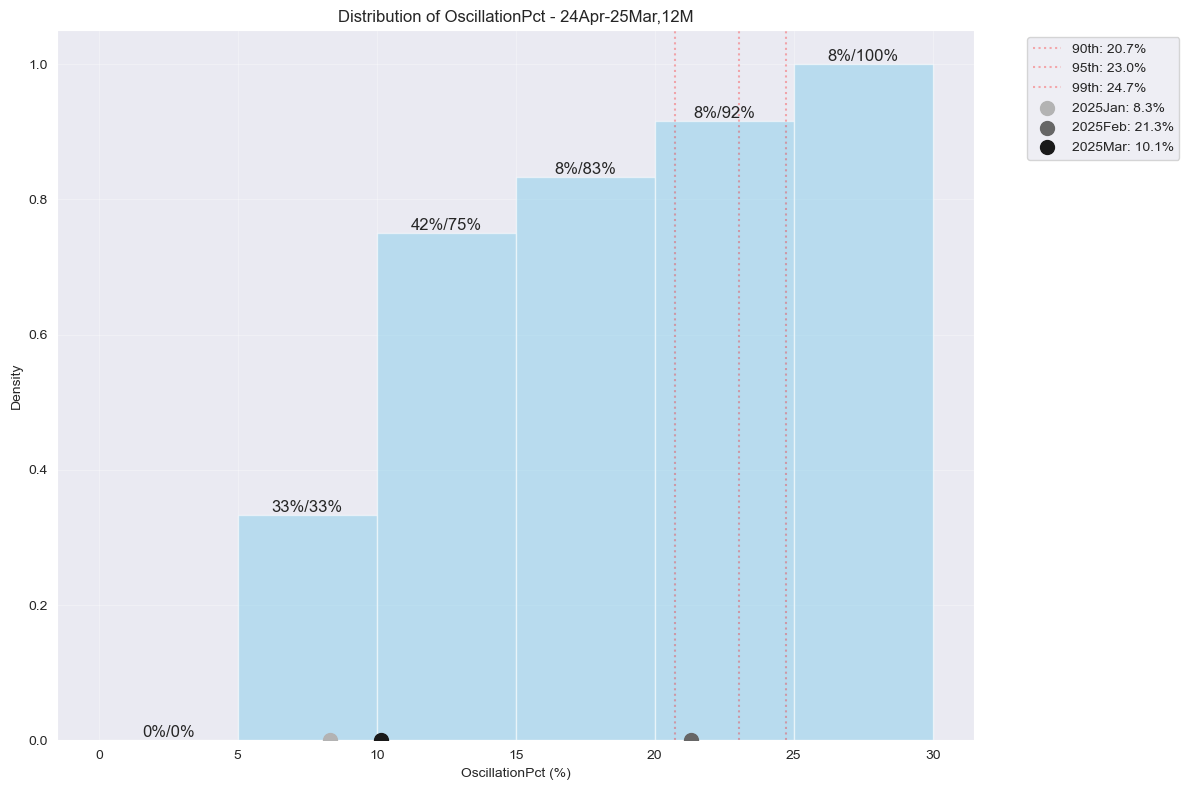

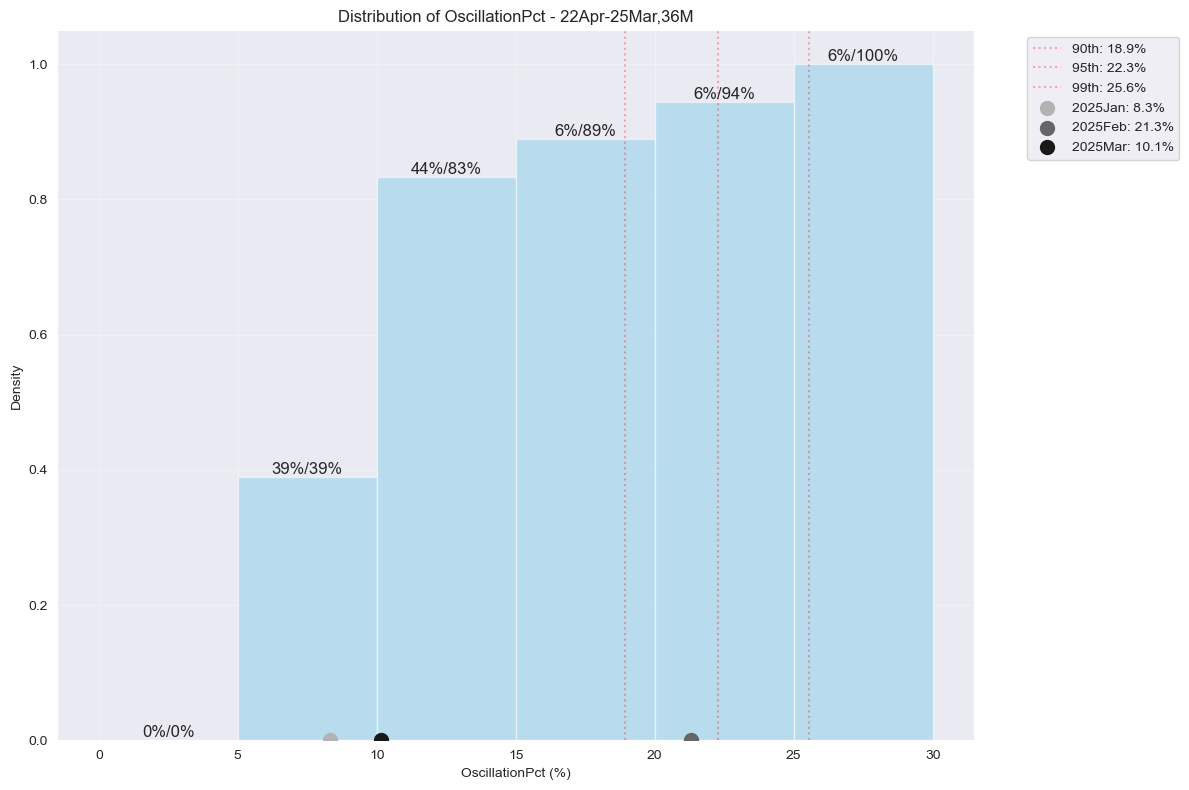

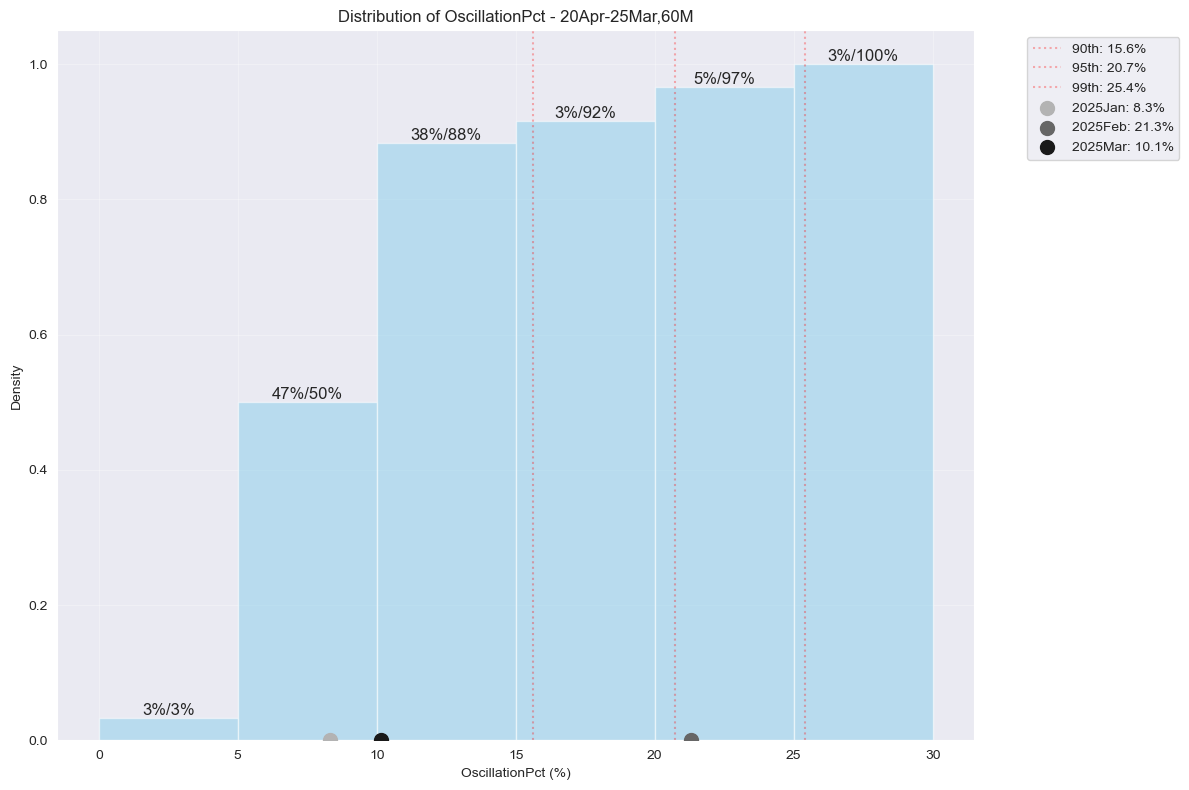

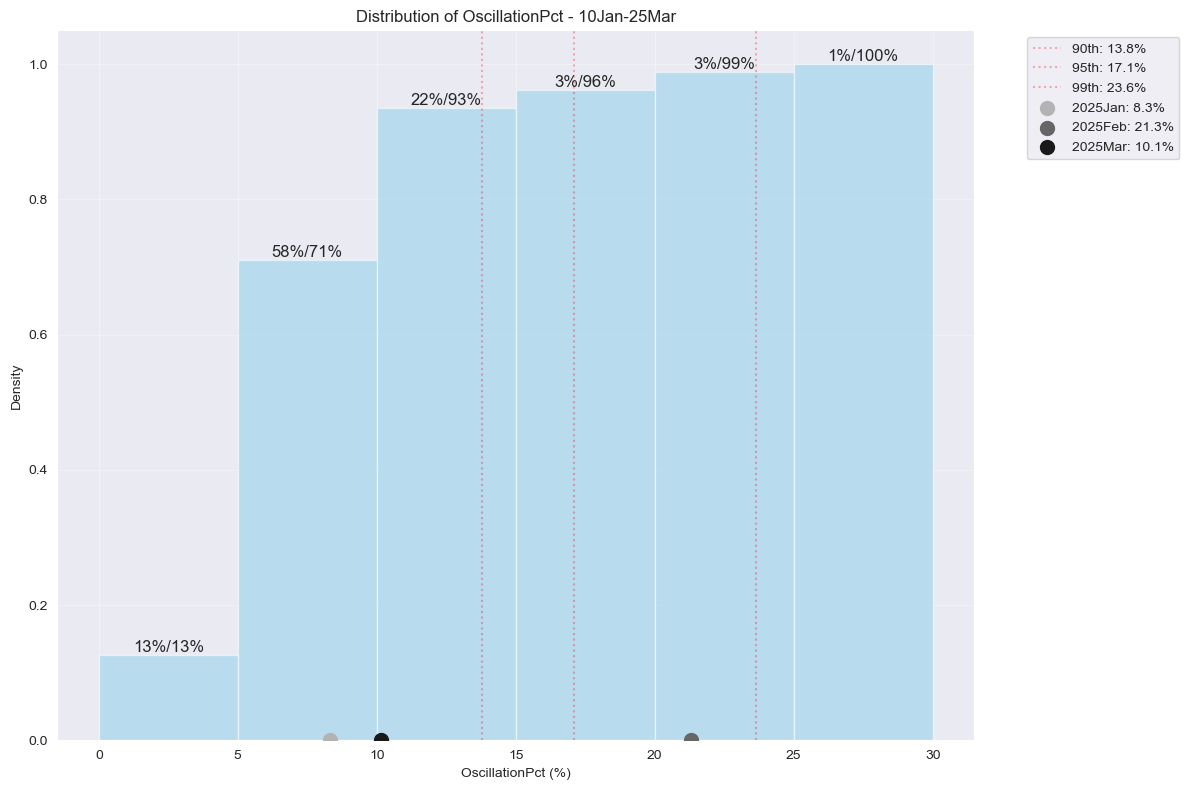

In [109]:
monthly_data = refrequency(data, frequency='ME')
monthly_oscill = oscillation(monthly_data)
tail_stats_result =tail_stats(monthly_oscill,"OscillationPct")
print(tail_stats_result.round(1))

tail_plot(monthly_oscill,"OscillationPct")

In [ ]:
# test
# mo.ChangeDistPlot(data, time_windows=['1Y', ('20240101', '20250401'), '100Y'], frequencies = ['W', 'M'])